# Data processing notebook

This notebook does two things:
 - Selects and prepares the data for analysis
 - Analyzes data and generates figures for use in other parts of the project (i.e. paper/presentation)

We note that some processing has already been done on the raw data before it went into our database, hence the 'preparation' steps taking place here are more part of the analysis and not cleanup/preprocessing steps.

We will also distinguish between components of this notebook that are specifically related to the data we are using for our 'case study', and what steps are generalizable to other data sets.

Let's begin.

## Part 1: selecting data and preparing for analysis

The following steps are related specifically to our data, from the Swiss National Bank.

### a) Estimate policy target where it doesn't exist
Beginning in July 2019 we have a policy target, before that we have only a daily data series containing an upper and lower target for the Swiss National Bank -> we need a single target with monthly observations.

Connect to the database, take the monthly average midpoint, index forward to the 1st of the following month (this is the convention we use across our data, August 1st represents July's numbers,etc.), and store in a dataframe.

In [3]:
import psycopg2
import os
import pandas as pd
from sqlalchemy import create_engine
from app.utils.config import settings

# Set up connection parameters from environment variables
dbname = settings.DBNAME
user = settings.READ_ONLY_DBUSER
password = settings.READ_ONLY_DBPASS
host = settings.DBHOST
port = settings.DBPORT

# Connect to the PostgreSQL database
conn_str = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(conn_str)

# SQL query
query = '''
WITH MonthlyAverages AS (
  SELECT
    DATE_TRUNC('month', date) + INTERVAL '1 month' - INTERVAL '1 day' AS date,
    AVG((lower_bound + upper_bound) / 2.0) AS value
  FROM
    targetranges
  GROUP BY
    DATE_TRUNC('month', date)
)
SELECT
  (date + INTERVAL '1 day')::date AS date,
  value
FROM
  MonthlyAverages

UNION ALL

SELECT
  '2000-01-01'::date AS report_date,
  (SELECT (lower_bound + upper_bound) / 2.0
   FROM targetranges
   ORDER BY date ASC
   LIMIT 1) AS value
ORDER BY
  date;
'''

# Read the data into a Pandas DataFrame
SNB_old = pd.read_sql_query(query, engine)

# Drop the last row from the DataFrame
SNB_old = SNB_old[:-1]

# Close the connection
engine.dispose()

# Show the resulting DataFrame
print(SNB_old.head())


         date     value
0  2000-01-01  1.750000
1  2000-02-01  1.750000
2  2000-03-01  2.202381
3  2000-04-01  2.478261
4  2000-05-01  3.000000


### b) Extract actual policy target where it does exist

Connect to the database and extract the policy target to a dataframe. Values for a month are reported as of the 1st of the following month.

In [4]:
import psycopg2
import os
import pandas as pd
from sqlalchemy import create_engine
from pandas.tseries.offsets import DateOffset

from app.utils.config import settings

# Set up connection parameters from environment variables
dbname = settings.DBNAME
user = settings.READ_ONLY_DBUSER
password = settings.READ_ONLY_DBPASS
host = settings.DBHOST
port = settings.DBPORT

# Connect to the PostgreSQL database
conn_str = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(conn_str)

# SQL query to select date and value from the targetrates table
query = '''
SELECT date, value FROM targetrates;
'''

# Read the data into a Pandas DataFrame
SNB_new = pd.read_sql_query(query, engine)

# Index the dates forward by one month to the first of the next month
SNB_new['date'] = pd.to_datetime(SNB_new['date']) + DateOffset(months=1)
SNB_new['date'] = SNB_new['date'].apply(lambda d: d.replace(day=1))

# Close the connection
engine.dispose()

# Print the resulting DataFrame
print(SNB_new.head())


        date  value
0 2019-07-01  -0.75
1 2019-08-01  -0.75
2 2019-09-01  -0.75
3 2019-10-01  -0.75
4 2019-11-01  -0.75


### c) Create a continuous policy target
Using SNB_new and SNB_old dataframes created in a) and b), create a new dataframe, SNB_policy which represents a continuous set of policy targets from January 2000 through present.

In [5]:
import pandas as pd

# Convert the 'date' columns in both DataFrames to pandas datetime format
SNB_old['date'] = pd.to_datetime(SNB_old['date'])
SNB_new['date'] = pd.to_datetime(SNB_new['date'])

# Merge SNB_old and SNB_new DataFrames
SNB_policy = pd.concat([SNB_old, SNB_new])

# Sort by date
SNB_policy.sort_values(by='date', inplace=True)

# Remove duplicates, keeping the first occurrence by default
SNB_policy.drop_duplicates(subset='date', keep='first', inplace=True)

# Print the resulting DataFrame
print(SNB_policy.head())


        date     value
0 2000-01-01  1.750000
1 2000-02-01  1.750000
2 2000-03-01  2.202381
3 2000-04-01  2.478261
4 2000-05-01  3.000000


### d) Extract deposit rate data
Connect to the database and extract savings deposit rate data from the SNB and offset by one month to match format of policy target dataset, SNB_policy.

In [6]:
import pandas as pd
from sqlalchemy import create_engine
from app.utils.config import settings

# Set up connection parameters from environment variables
dbname = settings.DBNAME
user = settings.DBUSER
password = settings.DBPASS
host = settings.DBHOST
port = settings.DBPORT

# Connect to the PostgreSQL database
conn_str = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(conn_str)

# SQL query to select date and value from the depositrates table
query = '''
SELECT date, value FROM depositrates;
'''

# Read the data into a Pandas DataFrame
SNB_deposit = pd.read_sql_query(query, engine)

# Convert the 'date' column to pandas datetime format and index forward by one month to the first of the next month
SNB_deposit['date'] = pd.to_datetime(SNB_deposit['date']) + pd.offsets.MonthBegin(1)

# Close the connection
engine.dispose()

# Print the resulting DataFrame
print(SNB_deposit.head())


        date  value
0 2000-01-01   1.19
1 2000-02-01   1.19
2 2000-03-01   1.27
3 2000-04-01   1.35
4 2000-05-01   1.35


### e) Create a single dataset
Create a combined dataset with policy targets and deposit rates for analysis.

In [7]:
import pandas as pd

# Merge SNB_policy and SNB_deposit on the 'date' column
SNB_data = pd.merge(SNB_policy[['date', 'value']], SNB_deposit[['date', 'value']], on='date', how='left')

# Rename the columns appropriately
SNB_data.rename(columns={'value_x': 'policy', 'value_y': 'deposit'}, inplace=True)

# Print the resulting DataFrame
print(SNB_data.head())


        date    policy  deposit
0 2000-01-01  1.750000     1.19
1 2000-02-01  1.750000     1.19
2 2000-03-01  2.202381     1.27
3 2000-04-01  2.478261     1.35
4 2000-05-01  3.000000     1.35


### f) Chart data so far
Chart policy target and deposit rates over time. Generate a PDF figure for later usage.

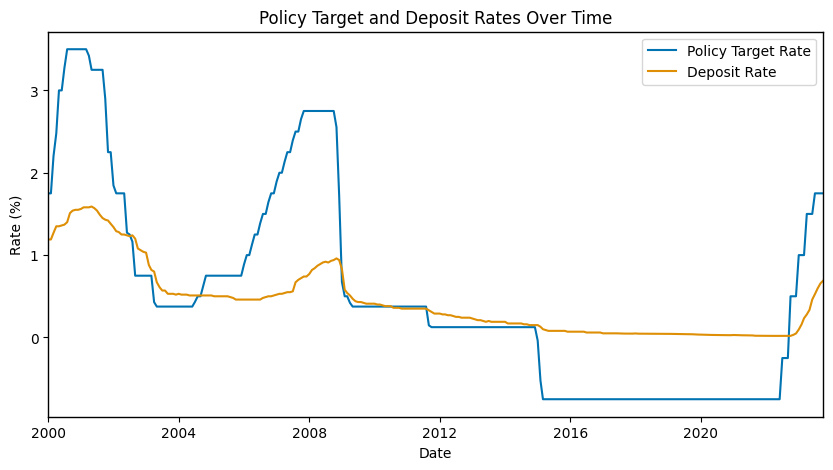

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  # For color-blind friendly palette
import os

# Convert 'date' to datetime if it's not already in that format
SNB_data['date'] = pd.to_datetime(SNB_data['date'])

# Set 'date' as the index
SNB_data.set_index('date', inplace=True)

# Set a color-blind-friendly palette from Seaborn
colors = sns.color_palette("colorblind")

# Create a figure with a white background
plt.figure(figsize=(10, 5), facecolor='white')

# Get the current axis and set the face color to white
ax = plt.gca()
ax.set_facecolor('white')

# Plotting with color-blind friendly colors
plt.plot(SNB_data.index, SNB_data['policy'], label='Policy Target Rate', color=colors[0])
plt.plot(SNB_data.index, SNB_data['deposit'], label='Deposit Rate', color=colors[1])

# Adding title and labels
plt.title('Policy Target and Deposit Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Rate (%)')

# Adding legend
plt.legend()

# Remove the grid
plt.grid(False)

# Add a black square line around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Adjust x-axis limits
data_start_date = SNB_data.index.min()
data_end_date = SNB_data.index.max()
ax.set_xlim(data_start_date, data_end_date)

# Check if the directory exists and create it if not
output_dir = '../reports/figures/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the plot as a PDF file in the specified directory
pdf_file_path = os.path.join(output_dir, 'rates_time_SNB.pdf')
plt.savefig(pdf_file_path, format='pdf', bbox_inches='tight', facecolor='white')

# Display the plot
plt.show()


## Part 2: Core Analysis
If using alternative data, you could start at this point, assuming some of the data selection and preparation would differ. What matters here is that you have a simple dataset containing monthly observations of policy and deposit rates (or economically similar data).

### a) Identification of rate hikes
Function to identify rate hikes
1. Initialization
Hiking List: Initializes a list named hiking, filled with False values, indicating that initially, no period is considered within a hiking cycle.
2. Primary Loop: Hiking Cycle Detection
Rate Increase Check: Starts from the second period, comparing the policy rate with the previous period.
If the rate is higher than the previous, marks it as part of a hiking cycle (True in hiking list).
If not an increase, but the previous was a hiking period, checks the next two periods:
Marks as the end of a cycle (False) if neither shows an increase.
Continues the cycle (True) if any of the next two show an increase.
3. Secondary Loop: Pre-Hiking Adjustment
Economic Anticipation: Adjusts for periods preceding a rate increase.
If a period is followed by an increasing rate, it is also marked as part of the cycle (True), capturing economic anticipation.
4. Special Case Handling
First Period: Treated uniquely. Set to True if the second period is part of a hiking cycle, indicating anticipation of a rate hike.
5. Finalization
DataFrame Update: The hiking list is assigned to the DataFrame's hiking column, indicating the hiking cycle status for each period.
Output: Returns the updated DataFrame with the hiking column.

In [9]:
import pandas as pd

def identify_hiking_cycles(df):
    hiking = [False] * len(df)  # Initialize the list with False

    # First loop: Set the 'hiking' status based on policy rate increases
    for i in range(1, len(df)):
        # If there is an increase in policy rate, set hiking to True
        if df['policy'].iloc[i] > df['policy'].iloc[i - 1]:
            hiking[i] = True
        # Check the next two periods if possible
        elif hiking[i - 1] and i < len(df) - 2:
            # If there are no increases in the next two periods, end the hiking cycle
            if not (df['policy'].iloc[i + 1] > df['policy'].iloc[i] or df['policy'].iloc[i + 2] > df['policy'].iloc[i]):
                hiking[i] = False
            else:
                # Otherwise, continue the hiking cycle
                hiking[i] = True

    # Second loop: Update the 'hiking' status to capture the period before the start of an actual hike
    for i in range(len(df) - 1):
        # If the next period is True, the current period should also be True
        if not hiking[i] and hiking[i + 1]:
            hiking[i] = True

    # Handle the special case of the first period
    if len(df) > 1 and not hiking[0] and hiking[1]:
        hiking[0] = True

    # Set the 'hiking' column in one go to avoid SettingWithCopyWarning
    df['hiking'] = hiking

    return df

# Apply the function to the SNB_data DataFrame
SNB_data = identify_hiking_cycles(SNB_data)

# Display the updated DataFrame
print(SNB_data.head())


              policy  deposit  hiking
date                                 
2000-01-01  1.750000     1.19    True
2000-02-01  1.750000     1.19    True
2000-03-01  2.202381     1.27    True
2000-04-01  2.478261     1.35    True
2000-05-01  3.000000     1.35    True


### b) Label hiking periods
Where continous periods have hiking = true, group and label these hiking periods

In [10]:
import pandas as pd

# Create a boolean series where we shift the 'hiking' column to compare with the next row
hiking_starts = (SNB_data['hiking'] & ~SNB_data['hiking'].shift(1).fillna(False))

# Use cumsum to create a unique identifier for each hiking period
SNB_data['hike_period_id'] = hiking_starts.cumsum()

# Now we create the 'hike_period' column which will be empty initially
SNB_data['hike_period'] = None

# Iterate over the unique hike period ids and set the 'hike_period' for rows where 'hiking' is True
for period_id in SNB_data['hike_period_id'].unique():
    if period_id != 0:  # We don't want to label the non-hiking periods
        SNB_data.loc[(SNB_data['hike_period_id'] == period_id) & SNB_data['hiking'],
                     'hike_period'] = f"hiking period {period_id}"

# Drop the intermediate 'hike_period_id' as it's no longer needed
SNB_data.drop('hike_period_id', axis=1, inplace=True)

# Display the updated DataFrame
print(SNB_data.head())


              policy  deposit  hiking      hike_period
date                                                  
2000-01-01  1.750000     1.19    True  hiking period 1
2000-02-01  1.750000     1.19    True  hiking period 1
2000-03-01  2.202381     1.27    True  hiking period 1
2000-04-01  2.478261     1.35    True  hiking period 1
2000-05-01  3.000000     1.35    True  hiking period 1


### c) Calculate summary statistics on hiking periods
Summarize hiking periods, add informative group labels with actual month/year and output to a PDF in '../reports/figures/'.

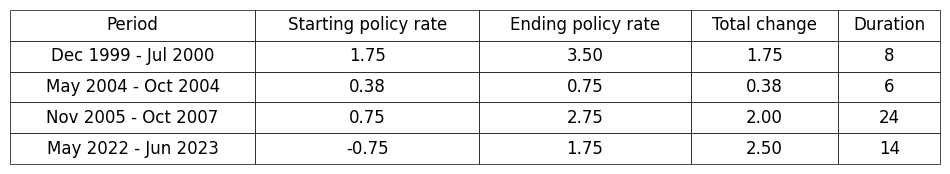

In [11]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import os

# Reset the index so that 'date' becomes a column
SNB_data_reset = SNB_data.reset_index()

# Filter the DataFrame to include only the rows where 'hike_period' is not None
hiking_data = SNB_data_reset.dropna(subset=['hike_period'])

# Group by 'hike_period' and calculate the summary statistics
hiking_summary = hiking_data.groupby('hike_period').agg(
    begin_date=('date', 'min'),
    end_date=('date', 'max'),
    begin_policy=('policy', 'first'),
    end_policy=('policy', 'last'),
    change_in_policy=('policy', lambda x: x.iloc[-1] - x.iloc[0]),
    hike_duration=('date', lambda x: ((x.max().year - x.min().year) * 12 + (x.max().month - x.min().month)) + 1)
).reset_index()

# Adjust 'begin_date' and 'end_date' to reflect the previous month's data
hiking_summary['begin_date'] = hiking_summary['begin_date'] - MonthEnd(1)
hiking_summary['end_date'] = hiking_summary['end_date'] - MonthEnd(1)

# Format the 'dates' column as 'month year - month year'
hiking_summary['dates'] = hiking_summary.apply(
    lambda row: f"{row['begin_date'].strftime('%b %Y')} - {row['end_date'].strftime('%b %Y')}", axis=1
)

# Round the decimal columns to two decimal places
hiking_summary['begin_policy'] = hiking_summary['begin_policy'].round(2)
hiking_summary['end_policy'] = hiking_summary['end_policy'].round(2)
hiking_summary['change_in_policy'] = hiking_summary['change_in_policy'].round(2)

# Select and order the columns
hiking_summary = hiking_summary[['dates', 'begin_policy', 'end_policy', 'change_in_policy', 'hike_duration']]

# Set the output directory for the figures
output_dir = '../reports/figures/'

# Check if the directory exists, if not, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set the style for nicer output
plt.style.use('ggplot')

# Create a new figure with size appropriate for your table
fig, ax = plt.subplots(figsize=(12, 2))  # Adjust the size as needed

# Hide the axes
ax.axis('off')

new_column_names = ['Period', 'Starting policy rate', 'Ending policy rate', 'Total change', 'Duration']

# Create the table with specific alignment for decimal columns
cell_text = hiking_summary.values
for row in cell_text:
    row[1] = f"{row[1]:.2f}"  # Format beginning policy rate
    row[2] = f"{row[2]:.2f}"  # Format ending policy rate
    row[3] = f"{row[3]:.2f}"  # Format change in policy rate

tbl = ax.table(cellText=cell_text,
               colLabels=new_column_names,
               cellLoc='center',  # Align cells to the center
               loc='center',
               bbox=[0, 0, 1, 1])

tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.auto_set_column_width(col=list(range(len(hiking_summary.columns))))

# Save the figure as PDF
pdf_filename = os.path.join(output_dir, 'hiking_summary_SNB.pdf')
plt.savefig(pdf_filename, bbox_inches='tight')

# Optionally display the figure if you're in a Jupyter environment
plt.show()


### d) Determine regions to shade for 'hiking cycles'
Create a dataframe to supply the dates for shading of hiking regions in the chart. Note that the logic we've used to this point would consider these first of month values to be the last month's data, however for shading, we leave as is.

In [10]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd

# Reset the index so that 'date' becomes a column
SNB_data_reset = SNB_data.reset_index()

# Filter the DataFrame to include only the rows where 'hike_period' is not None
hiking_data = SNB_data_reset.dropna(subset=['hike_period'])

# Group by 'hike_period' and calculate the start and end dates for each hiking cycle
hiking_regions = hiking_data.groupby('hike_period').agg(
    start_date=('date', 'min'),
    end_date=('date', 'max')
).reset_index()

# Display the 'hiking_regions' dataframe
print(hiking_regions)


       hike_period start_date   end_date
0  hiking period 1 2000-01-01 2000-08-01
1  hiking period 2 2004-06-01 2004-11-01
2  hiking period 3 2005-12-01 2007-11-01
3  hiking period 4 2022-06-01 2023-07-01


### e) Generate new interest rate chart with shaded regions for hiking cycles

NameError: name 'hiking_regions' is not defined

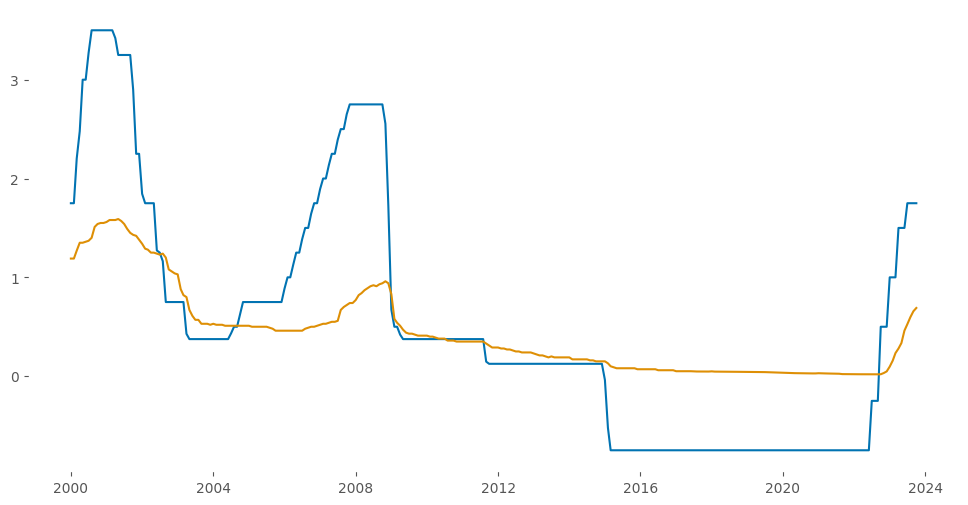

In [17]:
import pandas as pd  # noqa: E402
import matplotlib.pyplot as plt
import seaborn as sns  # For color-blind friendly palette
import os

# Assuming you have 'SNB_data' and 'hiking_regions' dataframes

# Set a color-blind-friendly palette from Seaborn
colors = sns.color_palette("colorblind")

# Create a white background figure
plt.figure(figsize=(12, 6), facecolor='white')

# Get the current axes
ax = plt.gca()
ax.set_facecolor('white')

# Plot the 'policy' rate and the 'deposit' rate using the color-blind friendly colors
plt.plot(SNB_data.index, SNB_data['policy'], label='Policy Rate', color=colors[0])
plt.plot(SNB_data.index, SNB_data['deposit'], label='Deposit Rate', color=colors[1])

# Shade the regions specified in 'hiking_regions'
for _, row in hiking_regions.iterrows():
    plt.axvspan(row['start_date'], row['end_date'], color='gray', alpha=0.3)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title('SNB Policy and Deposit Rates with Shaded Hiking Regions')
plt.legend()

# Remove the grid
plt.grid(False)

# Add a black square line around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Adjust x-axis limits
data_start_date = SNB_data.index.min()
data_end_date = SNB_data.index.max()
ax.set_xlim(data_start_date, data_end_date)

# Check if the directory exists and create it if not
output_dir = '../reports/figures/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the plot as a PDF file in the specified directory
pdf_file_path = os.path.join(output_dir, 'rates_shaded_SNB.pdf')
plt.savefig(pdf_file_path, format='pdf', bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()


### f) Identify periods of rising deposit rates
Identify periods where deposit rates continue rising following a increase in policy rates.

In [12]:
import pandas as pd

# Initialize the deposit_rising column with False
SNB_data['deposit_rising'] = False

def find_peak_deposit_post_hike(df):
    in_post_hike_period = False
    peak_deposit = -float('inf')
    
    for i in df.index:
        if df.at[i, 'hiking']:
            # If a new hiking cycle starts
            if in_post_hike_period:
                # Mark all remaining in post-hike period as False
                df.loc[(df.index > peak_index) & (df.index <= i), 'deposit_rising'] = False
            in_post_hike_period = False
            peak_deposit = -float('inf')
            df.at[i, 'deposit_rising'] = True
        else:
            if not in_post_hike_period and df.at[df.index[df.index.get_loc(i)-1], 'hiking']:
                # Hiking cycle just ended
                in_post_hike_period = True
                peak_deposit = df.at[i, 'deposit']
                peak_index = i
            if in_post_hike_period:
                # In post-hiking period, look for peak deposit rate
                if df.at[i, 'deposit'] > peak_deposit:
                    peak_deposit = df.at[i, 'deposit']
                    peak_index = i
                df.at[i, 'deposit_rising'] = True

    return df

# Apply the function to the DataFrame
SNB_data = find_peak_deposit_post_hike(SNB_data)

# To save the DataFrame as a CSV file
# SNB_data.to_csv('../reports/figures/SNB_data.csv', index=True) # this was just to make sure it was correct

print(SNB_data.head())


              policy  deposit  hiking      hike_period  deposit_rising
date                                                                  
2000-01-01  1.750000     1.19    True  hiking period 1            True
2000-02-01  1.750000     1.19    True  hiking period 1            True
2000-03-01  2.202381     1.27    True  hiking period 1            True
2000-04-01  2.478261     1.35    True  hiking period 1            True
2000-05-01  3.000000     1.35    True  hiking period 1            True


### g) Label deposit periods
Group and label periods of rising deposits.

In [13]:
# Add the deposit_period column
SNB_data['deposit_period'] = None

def label_deposit_periods(df):
    deposit_period_counter = 1
    current_period_label = None
    last_deposit_rising = False
    
    for i in df.index:
        if df.at[i, 'deposit_rising']:
            if not last_deposit_rising:
                # Start of a new deposit period
                current_period_label = f'Cycle {deposit_period_counter}'
                deposit_period_counter += 1
            df.at[i, 'deposit_period'] = current_period_label
        last_deposit_rising = df.at[i, 'deposit_rising']

    return df

# Apply the function to the DataFrame
SNB_data = label_deposit_periods(SNB_data)

# Display the DataFrame
print(SNB_data.head())


              policy  deposit  hiking      hike_period  deposit_rising  \
date                                                                     
2000-01-01  1.750000     1.19    True  hiking period 1            True   
2000-02-01  1.750000     1.19    True  hiking period 1            True   
2000-03-01  2.202381     1.27    True  hiking period 1            True   
2000-04-01  2.478261     1.35    True  hiking period 1            True   
2000-05-01  3.000000     1.35    True  hiking period 1            True   

           deposit_period  
date                       
2000-01-01        Cycle 1  
2000-02-01        Cycle 1  
2000-03-01        Cycle 1  
2000-04-01        Cycle 1  
2000-05-01        Cycle 1  


###  h) Summarize deposit periods and output to PDF.
Calculate summary statistics on periods of rising deposit rates and label informatively, generate PDF figure for later usage.

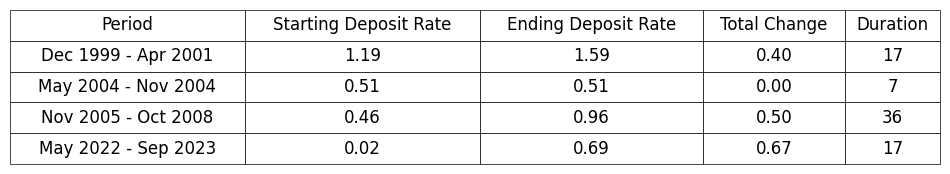

In [14]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import os

# Reset the index so that 'date' becomes a column
SNB_data_reset = SNB_data.reset_index()

# Filter the DataFrame to include only the rows where 'deposit_period' is not None
deposit_data = SNB_data_reset.dropna(subset=['deposit_period'])

# Group by 'deposit_period' and calculate the summary statistics
deposit_summary = deposit_data.groupby('deposit_period').agg(
    begin_date=('date', 'min'),
    end_date=('date', 'max'),
    begin_deposit=('deposit', 'first'),
    end_deposit=('deposit', 'last'),
    change_in_deposit=('deposit', lambda x: x.iloc[-1] - x.iloc[0]),
    deposit_duration=('date', lambda x: ((x.max().year - x.min().year) * 12 + (x.max().month - x.min().month)) + 1)
).reset_index()

# Adjust 'begin_date' and 'end_date' to reflect the previous month's data
deposit_summary['begin_date'] = deposit_summary['begin_date'] - MonthEnd(1)
deposit_summary['end_date'] = deposit_summary['end_date'] - MonthEnd(1)

# Format the 'dates' column as 'month year - month year'
deposit_summary['dates'] = deposit_summary.apply(
    lambda row: f"{row['begin_date'].strftime('%b %Y')} - {row['end_date'].strftime('%b %Y')}", axis=1
)

# Round the decimal columns to two decimal places
deposit_summary['begin_deposit'] = deposit_summary['begin_deposit'].round(2)
deposit_summary['end_deposit'] = deposit_summary['end_deposit'].round(2)
deposit_summary['change_in_deposit'] = deposit_summary['change_in_deposit'].round(2)

# Select and order the columns
deposit_summary = deposit_summary[['dates', 'begin_deposit', 'end_deposit', 'change_in_deposit', 'deposit_duration']]

# Set the output directory for the figures
output_dir = '../reports/figures/'

# Check if the directory exists, if not, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set the style for nicer output
plt.style.use('ggplot')

# Create a new figure with size appropriate for your table
fig, ax = plt.subplots(figsize=(12, 2))  # Adjust the size as needed

# Hide the axes
ax.axis('off')

new_column_names = ['Period', 'Starting Deposit Rate', 'Ending Deposit Rate', 'Total Change', 'Duration']

# Create the table with specific alignment for decimal columns
cell_text = deposit_summary.values
for row in cell_text:
    row[1] = f"{row[1]:.2f}"  # Format beginning deposit rate
    row[2] = f"{row[2]:.2f}"  # Format ending deposit rate
    row[3] = f"{row[3]:.2f}"  # Format change in deposit rate

tbl = ax.table(cellText=cell_text,
               colLabels=new_column_names,
               cellLoc='center',  # Align cells to the center
               loc='center',
               bbox=[0, 0, 1, 1])

tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.auto_set_column_width(col=list(range(len(deposit_summary.columns))))

# Save the figure as PDF
pdf_filename = os.path.join(output_dir, 'deposit_summary_SNB.pdf')
plt.savefig(pdf_filename, bbox_inches='tight')

# Optionally display the figure if you're in a Jupyter environment
plt.show()


### i) Calculate deposit betas
Where deposit rates are marked as rising(starting with hiking cycles and continuing to peak deposit rate), calculate the beta as total change in deposit over total change in policy since beginning of period (for both). There should be a beta for each period, except for the first in each hiking cycle which is really the last month of no change in policy rates.

In [15]:
import pandas as pd
import numpy as np

# Filter the DataFrame to include only rows where 'deposit_rising' is True
deposit_rising_data = SNB_data[SNB_data['deposit_rising']]

# Group by 'deposit_period' and calculate the deltas and running count (duration)
grouped = deposit_rising_data.groupby('deposit_period')
deposit_beta_SNB = deposit_rising_data.copy()
deposit_beta_SNB['policy_delta'] = grouped['policy'].transform(lambda x: x - x.iloc[0])
deposit_beta_SNB['deposit_delta'] = grouped['deposit'].transform(lambda x: x - x.iloc[0])
deposit_beta_SNB['duration'] = grouped.cumcount() + 1  # +1 to start counting from 1

# Calculate deposit_beta with the threshold condition
deposit_beta_SNB['deposit_beta'] = deposit_beta_SNB['deposit_delta'] / deposit_beta_SNB['policy_delta']
deposit_beta_SNB['deposit_beta'] = deposit_beta_SNB['deposit_beta'].apply(lambda x: x if x >= 0.01 else np.nan)

# Include deposit_period in the DataFrame
deposit_beta_SNB = deposit_beta_SNB[['deposit_period', 'policy', 'deposit', 'policy_delta', 'deposit_delta', 'deposit_beta', 'duration']]

# Display the DataFrame
print(deposit_beta_SNB.head())


           deposit_period    policy  deposit  policy_delta  deposit_delta  \
date                                                                        
2000-01-01        Cycle 1  1.750000     1.19      0.000000           0.00   
2000-02-01        Cycle 1  1.750000     1.19      0.000000           0.00   
2000-03-01        Cycle 1  2.202381     1.27      0.452381           0.08   
2000-04-01        Cycle 1  2.478261     1.35      0.728261           0.16   
2000-05-01        Cycle 1  3.000000     1.35      1.250000           0.16   

            deposit_beta  duration  
date                                
2000-01-01           NaN         1  
2000-02-01           NaN         2  
2000-03-01      0.176842         3  
2000-04-01      0.219701         4  
2000-05-01      0.128000         5  


### j) Plot deposit betas
Plot Deposit Betas calculated in earlier steps and manually remove hiking 'Cycle 2' from the chart. Generate PDF for future use.

***Removing Cycle 2 is specifically related to the economics in our own data, more info in our paper. Skip this step if you are not using SNB data.***

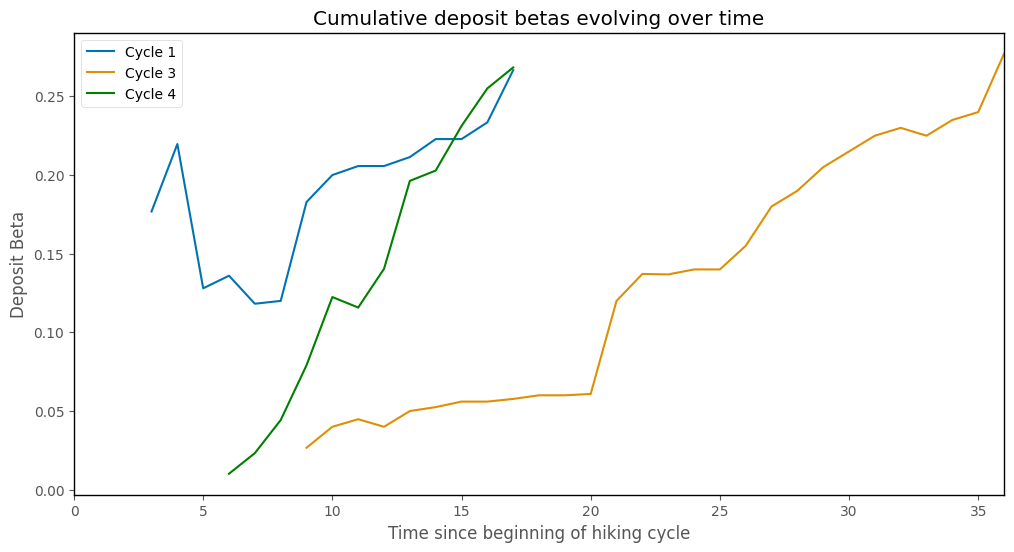

In [16]:
import seaborn as sns

# Set the color-blind-friendly palette from Seaborn
colors = sns.color_palette("colorblind")

# Create a white background figure
plt.figure(figsize=(12, 6), facecolor='white')

# Get the current axes and apply settings
ax = plt.gca()
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Remove the grid
plt.grid(False)

# Track the most recent deposit period
most_recent_period = deposit_beta_SNB['deposit_period'].max()

# Plot each deposit_period with specific color settings
for name, group in deposit_beta_SNB.groupby('deposit_period'):
    if name != 'Cycle 2':
        # Use blue and yellow for other periods and green for the most recent
        color = 'green' if name == most_recent_period else (colors[0] if '1' in name else colors[1])
        plt.plot(group['duration'], group['deposit_beta'], label=name, color=color)

# Add labels and title
plt.xlabel('Time since beginning of hiking cycle')
plt.ylabel('Deposit Beta')
plt.title('Cumulative deposit betas evolving over time')

# Create the legend with a white background
legend = plt.legend(facecolor='white')

# Adjust x-axis limits
plt.xlim(0, deposit_beta_SNB['duration'].max())

# Save the plot as a PDF file in the specified directory
output_dir = '../reports/figures/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
pdf_file_path = os.path.join(output_dir, 'deposit_beta_SNB.pdf')
plt.savefig(pdf_file_path, format='pdf', bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()
